In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats
import seaborn as sns
from warnings import simplefilter
from sklearn.exceptions import ConvergenceWarning
simplefilter("ignore", category=ConvergenceWarning)
from sklearn.model_selection import GridSearchCV

In [2]:
#Read in the data
df = pd.read_csv('cancerDataframe.csv')

#Feature selection
percentile = np.percentile(df.iloc[:,2:], 80, axis=0)
percentile = np.reshape(percentile, (1, len(percentile)))
np_df = df.iloc[:,2:].to_numpy()
np_first2 = df.iloc[:,0:2].to_numpy()

boolean = 1 * (np_df >= percentile)
boolean.shape
boolean = np.concatenate((np_first2, boolean), axis=1)

df_top20 = pd.DataFrame(boolean, columns = df.columns)

In [3]:
print(np.bincount(df_top20.iloc[:,0]))
np.shape(df_top20)

[1096  544  519  478  178   80]


(2895, 1883)

In [4]:
#Split the data
from sklearn.model_selection import train_test_split, cross_val_score

X = df_top20.iloc[:,2:]
y = df.iloc[:,0]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)

In [5]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score, mean_squared_error

kn = 3

knn = KNeighborsClassifier(n_neighbors=kn)
#knn.fit(X_train, y_train)
scores = cross_val_score(knn, X_train, y_train, cv=10, scoring='f1_macro', error_score="raise")
print('CV score:', scores.mean(), "+/-", scores.std())


#y_pred = knn.predict(test_images)
#final_score = f1_score(y_pred, test_labels, average='macro')
#print(final_score)

CV score: 0.8353335117386024 +/- 0.01888265190826474


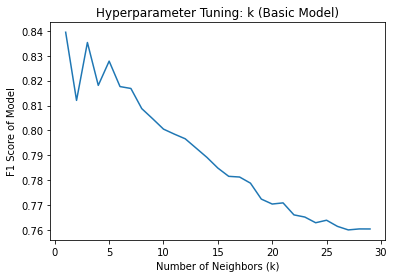

In [6]:
#Tuning
k_lst = []
f1_lst = []

for k in range(1,30):
    k_lst.append(k)
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)
    scores = cross_val_score(knn, X_train, y_train, cv=10, scoring='f1_macro', error_score="raise")
    f1_lst.append(scores.mean())

plt.plot(k_lst, f1_lst)
plt.xlabel('Number of Neighbors (k)')
plt.ylabel('F1 Score of Model')
plt.title('Hyperparameter Tuning: k (Basic Model)')
plt.show
plt.savefig('tuning_k_basic.pdf', bbox_inches='tight')

In [7]:
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import confusion_matrix
model = SGDClassifier(loss = 'log_loss')

scores = cross_val_score(model, X_train, y_train, cv=10, scoring='f1_macro', error_score="raise")
print(scores.mean())

0.9709285396475515


In [21]:
#SGD classifier cross validation
parameters = {'penalty':['l2'], 'alpha':[0.0001, 0.01, 0.1, 1.0, 10], 'eta0':[0, 0.001, 0.01, 0.1, 1.0]}
svc = SGDClassifier(loss = 'log_loss')
clf = GridSearchCV(svc, parameters, scoring='f1_macro', cv=10)
clf.fit(X_train, y_train)
for key in clf.cv_results_.keys():
    print(key)
    print(clf.cv_results_.get(key))

mean_fit_time
[1.13765976 1.12659061 1.08628528 1.12465315 1.0955503  0.81959143
 0.8368938  0.82741821 0.81903243 0.81364927 0.67261834 0.6527633
 0.64640207 0.66149666 0.68131807 0.6688761  0.66865158 0.65489209
 0.68242853 0.67904408 0.58642957 0.58164973 0.58267736 0.58921232
 0.58804946]
std_fit_time
[0.07600158 0.07406215 0.05948161 0.03358453 0.06590348 0.0269901
 0.01984593 0.03681423 0.02839766 0.03028866 0.03405503 0.0295969
 0.03613978 0.03612913 0.02662815 0.0246373  0.03340256 0.02201278
 0.03989543 0.04373694 0.02090591 0.01408655 0.01478918 0.01303591
 0.01667294]
mean_score_time
[0.02274795 0.02451022 0.02365167 0.02284532 0.02262554 0.02270896
 0.02266204 0.02276781 0.02264907 0.02275305 0.02264614 0.02266827
 0.02278504 0.02300446 0.02285831 0.02267816 0.02264602 0.022686
 0.02286685 0.02264912 0.02268963 0.02267258 0.02267056 0.02303865
 0.0226922 ]
std_score_time
[1.98348892e-04 5.38516033e-03 2.53262501e-03 3.15300378e-04
 1.13616707e-04 9.85125287e-05 7.65147033e-

In [13]:
from sklearn.svm import LinearSVC

def linear():
    model = LinearSVC()
    scores = cross_val_score(model, X_train, y_train, cv=10, scoring='f1_macro', error_score="raise")
    print('CV score:', scores.mean(), "+/-", scores.std())
    
linear()

#decrease the max number of iterations

CV score: 0.9719936923425377 +/- 0.006924937788749169


<function matplotlib.pyplot.show(close=None, block=None)>

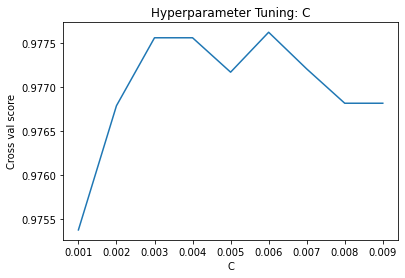

In [14]:
#Tuning SVM
i = 0.001

C_lst = []
score_lst = []

while i <= 0.01:
    C_lst.append(i)
    model = LinearSVC(C = i)
    scores = cross_val_score(model, X_train, y_train, cv=10, scoring='f1_macro', error_score="raise")
    score_lst.append(scores.mean())
    i += 0.001
    
plt.plot(C_lst, score_lst)
plt.xlabel('C')
plt.ylabel('Cross val score')
plt.title('Hyperparameter Tuning: C')
plt.show


In [18]:
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_predict

model = SVC()
scores = cross_val_score(model, X_train, y_train, cv=10, scoring='f1_macro', error_score="raise")
print('CV score:', scores.mean(), "+/-", scores.std())

CV score: 0.9722414526753393 +/- 0.009023049031284125


<function matplotlib.pyplot.show(close=None, block=None)>

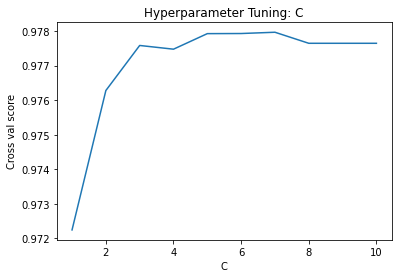

In [20]:
#Tuning SVM
i = 1.0

C_lst = []
score_lst = []

while i <= 10.0:
    C_lst.append(i)
    model = SVC(C = i)
    scores = cross_val_score(model, X_train, y_train, cv=10, scoring='f1_macro', error_score="raise")
    score_lst.append(scores.mean())
    i += 1.0
    
plt.plot(C_lst, score_lst)
plt.xlabel('C')
plt.ylabel('Cross val score')
plt.title('Hyperparameter Tuning: C')
plt.show

#optimal C: 7.0
#grid search kernel width for SVC

In [23]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier()
scores = cross_val_score(model, X_train, y_train, cv=10, scoring='f1_macro', error_score="raise")
print('CV score:', scores.mean(), "+/-", scores.std())

CV score: 0.9621660240025506 +/- 0.007080853586927267


<function matplotlib.pyplot.show(close=None, block=None)>

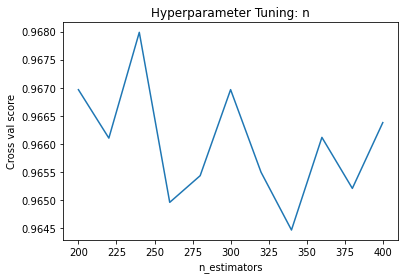

In [25]:
#Tuning Random Forest
i = 200

n_lst = [] #n_estimators 20-200
score_lst = []

while i <= 400:
    n_lst.append(i)
    model = RandomForestClassifier(n_estimators = i)
    scores = cross_val_score(model, X_train, y_train, cv=10, scoring='f1_macro', error_score="raise")
    score_lst.append(scores.mean())
    i += 20

plt.plot(n_lst, score_lst)
plt.xlabel('n_estimators')
plt.ylabel('Cross val score')
plt.title('Hyperparameter Tuning: n')
plt.show

#.968 for n_estimators = 240

In [27]:
from sklearn.neural_network import MLPClassifier

nn = MLPClassifier(random_state=1, max_iter=300)
parameters = {'alpha':[0.0001, 0.01, 0.1, 1.0, 10], 'learning_rate_init':[0.0001, 0.001, 0.01, 0.1, 1.0]}
clf = GridSearchCV(nn, parameters, scoring='f1_macro', cv=2)
clf.fit(X_train, y_train)
for key in clf.cv_results_.keys():
    print(key)
    print(clf.cv_results_.get(key))
    
#{'alpha': 0.01, 'learning_rate_init': 0.001}

mean_fit_time
[14.67729425  6.19918334  3.91816247  3.97101736  0.90264225 14.88895249
  6.03864288  6.63572478  0.94173217  0.80172765 15.71001554 15.77628291
  3.00549531 15.86498523  0.82322204 16.87758911 12.39474928  3.20622957
  1.81316924  0.82556546 16.95063484  6.57982981  2.2602284   0.80652726
  0.77785504]
std_fit_time
[1.77141428e-01 1.13846064e-02 2.25305200e-01 6.99775696e-01
 2.07233429e-02 1.28664494e-01 6.83879852e-02 5.11940956e-01
 7.39097595e-05 7.74204731e-03 3.36656570e-02 1.08915389e+00
 1.68817759e-01 6.01210594e-01 5.75721264e-03 6.45498037e-02
 5.20936608e-01 5.10698915e-01 1.51848793e-02 2.50327587e-03
 1.19036436e-02 7.31372952e-01 1.23553276e-02 1.09618902e-02
 5.99062443e-03]
mean_score_time
[0.12627637 0.12625921 0.12575591 0.12559998 0.1256007  0.1259563
 0.12649417 0.12572503 0.12558138 0.12491059 0.12635875 0.12633312
 0.12578762 0.12596107 0.12582433 0.1261754  0.12660956 0.12573433
 0.12619424 0.12552881 0.1266582  0.12583852 0.12635863 0.125718
 0.